In [1]:
import numpy as np
import pandas as pd
import scipy 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [50]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

First thing first, let's import our data and see what it looks like

In [51]:
dataframe = pd.read_csv('../dataset/life_expectancy.csv')
dataframe.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


We're need a list of numerical feature, we're gonna need it to check correlation later.

In [52]:
initial_comlumn=list(dataframe.columns)
initial_comlumn.remove('Status')
initial_comlumn.remove('Country')

In [53]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

Let's see how many nulls value in each feature of this dataframe

In [54]:
columns = list(dataframe.columns)
for i in columns:
    print(i, ": ", dataframe[i].isnull().sum())

Country :  0
Year :  0
Status :  0
Life expectancy  :  10
Adult Mortality :  10
infant deaths :  0
Alcohol :  194
percentage expenditure :  0
Hepatitis B :  553
Measles  :  0
 BMI  :  34
under-five deaths  :  0
Polio :  19
Total expenditure :  226
Diphtheria  :  19
 HIV/AIDS :  0
GDP :  448
Population :  652
 thinness  1-19 years :  34
 thinness 5-9 years :  34
Income composition of resources :  167
Schooling :  163


As we can see, 'Life Expectancy' and 'Adult morality' has few null values, so we can fill them with mean value.


In [55]:
dataframe['Life expectancy ']= dataframe['Life expectancy '].fillna(value=dataframe['Life expectancy '].mean())
dataframe['Adult Mortality']= dataframe['Adult Mortality'].fillna(value=dataframe['Adult Mortality'].mean())


Since our regression model cannot handle categorical features. Plus, converting categorical to numeric before spliting the dataframe into train and test can lead to the difference in size of the train and test set. So, we should convert these features now.

In [56]:

Country_dummy=pd.get_dummies(dataframe['Country'])
status_dummy=pd.get_dummies(dataframe['Status'])
dataframe.drop(['Country','Status'],inplace=True,axis=1)
dataframe=pd.concat([dataframe,Country_dummy,status_dummy],axis=1)


Now we split our data into 2 subsets: train set and test set

In [57]:
train , test = train_test_split(dataframe,test_size=0.3, random_state= 42)

Now, let's handle our test set first, let's see if there is any null value in here.

In [58]:
columns = list(test.columns)
for i in columns:
    print(i, ": ", test[i].isnull().sum())

Year :  0
Life expectancy  :  0
Adult Mortality :  0
infant deaths :  0
Alcohol :  58
percentage expenditure :  0
Hepatitis B :  183
Measles  :  0
 BMI  :  10
under-five deaths  :  0
Polio :  8
Total expenditure :  68
Diphtheria  :  8
 HIV/AIDS :  0
GDP :  151
Population :  208
 thinness  1-19 years :  10
 thinness 5-9 years :  10
Income composition of resources :  57
Schooling :  54
Afghanistan :  0
Albania :  0
Algeria :  0
Angola :  0
Antigua and Barbuda :  0
Argentina :  0
Armenia :  0
Australia :  0
Austria :  0
Azerbaijan :  0
Bahamas :  0
Bahrain :  0
Bangladesh :  0
Barbados :  0
Belarus :  0
Belgium :  0
Belize :  0
Benin :  0
Bhutan :  0
Bolivia (Plurinational State of) :  0
Bosnia and Herzegovina :  0
Botswana :  0
Brazil :  0
Brunei Darussalam :  0
Bulgaria :  0
Burkina Faso :  0
Burundi :  0
Cabo Verde :  0
Cambodia :  0
Cameroon :  0
Canada :  0
Central African Republic :  0
Chad :  0
Chile :  0
China :  0
Colombia :  0
Comoros :  0
Congo :  0
Cook Islands :  0
Costa Rica

Because this is a test set, we should not linearize this so as to avoid overfitting, we can only fill them with their mean values of the whole records of each feature.

In [59]:
test['Alcohol']=test['Alcohol'].fillna(value=dataframe['Alcohol'].mean())
test['Adult Mortality']=test['Adult Mortality'].fillna(value=dataframe['Adult Mortality'].mean())
test['Hepatitis B']=test['Hepatitis B'].fillna(value=dataframe['Hepatitis B'].mean())
test['Polio']=test['Polio'].fillna(value=dataframe['Polio'].mean())
test['Total expenditure']=test['Total expenditure'].fillna(value=dataframe['Total expenditure'].mean())
test['Diphtheria ']=test['Diphtheria '].fillna(value=dataframe['Diphtheria '].mean())
test['GDP']=test['GDP'].fillna(value=dataframe['GDP'].mean())
test['Population']=test['Population'].fillna(value=dataframe['Population'].mean())
test[' thinness  1-19 years']=test[' thinness  1-19 years'].fillna(value=dataframe[' thinness  1-19 years'].mean())
test[' thinness 5-9 years']=test[' thinness 5-9 years'].fillna(value=dataframe[' thinness 5-9 years'].mean())
test['Income composition of resources']=test['Income composition of resources'].fillna(value=dataframe['Income composition of resources'].mean())
test['Schooling']=test['Schooling'].fillna(value=dataframe['Schooling'].mean())
test[' BMI ']=test[' BMI '].fillna(value=dataframe[' BMI '].mean())

Now let's check if we have cleared all the null value in the test set yet.

In [60]:
columns = list(test.columns)
for i in columns:
    print(i, ": ", test[i].isnull().sum())

Year :  0
Life expectancy  :  0
Adult Mortality :  0
infant deaths :  0
Alcohol :  0
percentage expenditure :  0
Hepatitis B :  0
Measles  :  0
 BMI  :  0
under-five deaths  :  0
Polio :  0
Total expenditure :  0
Diphtheria  :  0
 HIV/AIDS :  0
GDP :  0
Population :  0
 thinness  1-19 years :  0
 thinness 5-9 years :  0
Income composition of resources :  0
Schooling :  0
Afghanistan :  0
Albania :  0
Algeria :  0
Angola :  0
Antigua and Barbuda :  0
Argentina :  0
Armenia :  0
Australia :  0
Austria :  0
Azerbaijan :  0
Bahamas :  0
Bahrain :  0
Bangladesh :  0
Barbados :  0
Belarus :  0
Belgium :  0
Belize :  0
Benin :  0
Bhutan :  0
Bolivia (Plurinational State of) :  0
Bosnia and Herzegovina :  0
Botswana :  0
Brazil :  0
Brunei Darussalam :  0
Bulgaria :  0
Burkina Faso :  0
Burundi :  0
Cabo Verde :  0
Cambodia :  0
Cameroon :  0
Canada :  0
Central African Republic :  0
Chad :  0
Chile :  0
China :  0
Colombia :  0
Comoros :  0
Congo :  0
Cook Islands :  0
Costa Rica :  0
Croatia

Ok, we're done with the test set, now it's time we do something to our train set. Let's check which feature of our train set has null values.

In [61]:
columns = list(train.columns)
for i in columns:
    print(i, ": ", train[i].isnull().sum())

Year :  0
Life expectancy  :  0
Adult Mortality :  0
infant deaths :  0
Alcohol :  136
percentage expenditure :  0
Hepatitis B :  370
Measles  :  0
 BMI  :  24
under-five deaths  :  0
Polio :  11
Total expenditure :  158
Diphtheria  :  11
 HIV/AIDS :  0
GDP :  297
Population :  444
 thinness  1-19 years :  24
 thinness 5-9 years :  24
Income composition of resources :  110
Schooling :  109
Afghanistan :  0
Albania :  0
Algeria :  0
Angola :  0
Antigua and Barbuda :  0
Argentina :  0
Armenia :  0
Australia :  0
Austria :  0
Azerbaijan :  0
Bahamas :  0
Bahrain :  0
Bangladesh :  0
Barbados :  0
Belarus :  0
Belgium :  0
Belize :  0
Benin :  0
Bhutan :  0
Bolivia (Plurinational State of) :  0
Bosnia and Herzegovina :  0
Botswana :  0
Brazil :  0
Brunei Darussalam :  0
Bulgaria :  0
Burkina Faso :  0
Burundi :  0
Cabo Verde :  0
Cambodia :  0
Cameroon :  0
Canada :  0
Central African Republic :  0
Chad :  0
Chile :  0
China :  0
Colombia :  0
Comoros :  0
Congo :  0
Cook Islands :  0
Cost

Since other features has great amount of null values, we're gonna fill each of these feature one by one so that we won't mislead the original structure of the dataframe.
Since these feature has great amount of null, then filling them with means is no longer "good", we're gonna fill these gaps by using correlations with other features. To do this let us first see the correlation matrix of these features using '.corr' method by pandas.

However, since we have already used 'get_dummies' to change our categorical feature to numeric, so that the size of our dataframe is now very huge, to check the correlation of our data, we only consider the columns before using 'get_dummies'

In [62]:
corr_data=dataframe[initial_comlumn].corr()
corr_data

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.169623,-0.078861,-0.037415,-0.052990,0.031400,0.104333,-0.082493,0.108974,-0.042937,0.094158,0.090740,0.134337,-0.139741,0.101620,0.016969,-0.047876,-0.050929,0.243468,0.209400
Life expectancy,0.169623,1.000000,-0.696359,-0.196535,0.404029,0.381791,0.255760,-0.157574,0.564466,-0.222503,0.464531,0.216373,0.478465,-0.556457,0.461393,-0.021548,-0.476561,-0.470977,0.724631,0.748263
Adult Mortality,-0.078861,-0.696359,1.000000,0.078747,-0.195454,-0.242814,-0.161828,0.031174,-0.384806,0.094135,-0.274218,-0.114355,-0.274540,0.523727,-0.296019,-0.013639,0.302501,0.308053,-0.457530,-0.452380
infant deaths,-0.037415,-0.196535,0.078747,1.000000,-0.115638,-0.085612,-0.223566,0.501128,-0.227279,0.996629,-0.170689,-0.128616,-0.175171,0.025231,-0.108427,0.556801,0.465711,0.471350,-0.145139,-0.193720
Alcohol,-0.052990,0.404029,-0.195454,-0.115638,1.000000,0.341285,0.087549,-0.051827,0.330408,-0.112370,0.221734,0.296942,0.222020,-0.048845,0.354712,-0.035252,-0.428795,-0.417414,0.450040,0.547378
percentage expenditure,0.031400,0.381791,-0.242814,-0.085612,0.341285,1.000000,0.016274,-0.056596,0.228700,-0.087852,0.147259,0.174420,0.143624,-0.097857,0.899373,-0.025662,-0.251369,-0.252905,0.381952,0.389687
Hepatitis B,0.104333,0.255760,-0.161828,-0.223566,0.087549,0.016274,1.000000,-0.120529,0.150380,-0.233126,0.486171,0.058280,0.611495,-0.112675,0.083903,-0.123321,-0.120429,-0.124960,0.199549,0.231117
Measles,-0.082493,-0.157574,0.031174,0.501128,-0.051827,-0.056596,-0.120529,1.000000,-0.175977,0.507809,-0.136166,-0.106241,-0.141882,0.030899,-0.076466,0.265966,0.224808,0.221072,-0.129568,-0.137225
BMI,0.108974,0.564466,-0.384806,-0.227279,0.330408,0.228700,0.150380,-0.175977,1.000000,-0.237669,0.284569,0.242503,0.283147,-0.243717,0.301557,-0.072301,-0.532025,-0.538911,0.508774,0.546961
under-five deaths,-0.042937,-0.222503,0.094135,0.996629,-0.112370,-0.087852,-0.233126,0.507809,-0.237669,1.000000,-0.188720,-0.130148,-0.195668,0.038062,-0.112081,0.544423,0.467789,0.472263,-0.163305,-0.209373


Let's start with our first feature: Alcohol, from table above we can see that 'Schooling' is a feature which has good correlation with 'Alcohol' (0.54738). Let's observe them in a scatter plot


<AxesSubplot:xlabel='Schooling', ylabel='Alcohol'>

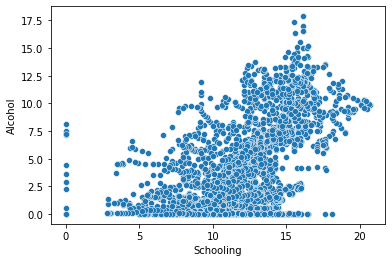

In [63]:
sns.scatterplot(x=dataframe['Schooling'],y=dataframe['Alcohol'])

Let's fill null value of 'Alcohol' with their mean value with respect to 'Schooling' interval

In [64]:


def impute_Alcohol(cols):
    al=cols[0]
    sc=cols[1]
    if pd.isnull(al):
        if sc<=2.5:
            return train[train['Schooling']<=2.5]['Alcohol'].mean()
        elif 2.5<sc<=5.0:
            return train[(2.5<train['Schooling']) &(train['Schooling'] <=5)]['Alcohol'].mean()
        elif 5.0<sc<=7.5:
            return train[(5<train['Schooling']) &(train['Schooling'] <=7.5)]['Alcohol'].mean()
        elif 7.5<sc<=10.0:
            return train[(7.5<train['Schooling']) &(train['Schooling'] <=10)]['Alcohol'].mean()
        elif 10.0<sc<=12.5:
            return train[(10<train['Schooling']) &(train['Schooling'] <=12.5)]['Alcohol'].mean()
        elif 12.5<sc<=15:
            return train[(12.5<train['Schooling']) &(train['Schooling'] <=15)]['Alcohol'].mean()
        elif sc>15:
            return train[train['Schooling']>15]['Alcohol'].mean()
    else:
        return al
    
train['Alcohol']=train[['Alcohol','Schooling']].apply(impute_Alcohol,axis=1)


In [65]:
columns = list(train.columns)
for i in columns:
    print(i, ": ", train[i].isnull().sum())

Year :  0
Life expectancy  :  0
Adult Mortality :  0
infant deaths :  0
Alcohol :  6
percentage expenditure :  0
Hepatitis B :  370
Measles  :  0
 BMI  :  24
under-five deaths  :  0
Polio :  11
Total expenditure :  158
Diphtheria  :  11
 HIV/AIDS :  0
GDP :  297
Population :  444
 thinness  1-19 years :  24
 thinness 5-9 years :  24
Income composition of resources :  110
Schooling :  109
Afghanistan :  0
Albania :  0
Algeria :  0
Angola :  0
Antigua and Barbuda :  0
Argentina :  0
Armenia :  0
Australia :  0
Austria :  0
Azerbaijan :  0
Bahamas :  0
Bahrain :  0
Bangladesh :  0
Barbados :  0
Belarus :  0
Belgium :  0
Belize :  0
Benin :  0
Bhutan :  0
Bolivia (Plurinational State of) :  0
Bosnia and Herzegovina :  0
Botswana :  0
Brazil :  0
Brunei Darussalam :  0
Bulgaria :  0
Burkina Faso :  0
Burundi :  0
Cabo Verde :  0
Cambodia :  0
Cameroon :  0
Canada :  0
Central African Republic :  0
Chad :  0
Chile :  0
China :  0
Colombia :  0
Comoros :  0
Congo :  0
Cook Islands :  0
Costa 

Since 'Schooling' in not non-null, which means there still exists 'Alcohol' null values that failed to fill. Let's fill them with mean value

In [66]:
train['Alcohol']=train['Alcohol'].fillna(value=dataframe['Alcohol'].mean())

Next, let's handle 'Herpatitis B', from the correlation table above, we can see a great correalation with 'Polio'. However, from previous consideration, since 'Polio' is also not non-null, then it would be no use.
So, we're gonna handle 'Polio' with 'Life Expectancy' first since 'Life Expectancy' is non-null and they're well-correlated

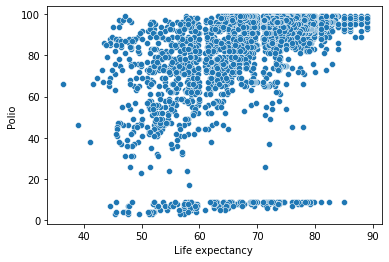

In [67]:
sns.scatterplot(x=dataframe['Life expectancy '],y=dataframe['Polio']);

In [68]:
def impute_polio(c):
    p=c[0]
    l=c[1]
    if pd.isnull(p):
        if l<=45:
            return train[train['Life expectancy ']<=45]['Polio'].mean()
        elif 45<l<=50:
            return train[(45<train['Life expectancy ']) &(train['Life expectancy '] <=50)]['Polio'].mean()
        elif 50<l<=60:
            return train[(50<train['Life expectancy ']) &(train['Life expectancy '] <=60)]['Polio'].mean()
        elif 60<l<=70:
            return train[(60<train['Life expectancy ']) &(train['Life expectancy '] <=70)]['Polio'].mean()
        elif 70<l<=80:
            return train[(70<train['Life expectancy ']) &(train['Life expectancy '] <=80)]['Polio'].mean()
        elif l>80:
            return train[train['Life expectancy ']>80]['Polio'].mean()
    else:
        return p
    
train['Polio']=train[['Polio','Life expectancy ']].apply(impute_polio,axis=1)

Let's check if 'Polio' has filled all null values or not

In [69]:
columns = list(train.columns)
for i in columns:
    print(i, ": ", train[i].isnull().sum())

Year :  0
Life expectancy  :  0
Adult Mortality :  0
infant deaths :  0
Alcohol :  0
percentage expenditure :  0
Hepatitis B :  370
Measles  :  0
 BMI  :  24
under-five deaths  :  0
Polio :  0
Total expenditure :  158
Diphtheria  :  11
 HIV/AIDS :  0
GDP :  297
Population :  444
 thinness  1-19 years :  24
 thinness 5-9 years :  24
Income composition of resources :  110
Schooling :  109
Afghanistan :  0
Albania :  0
Algeria :  0
Angola :  0
Antigua and Barbuda :  0
Argentina :  0
Armenia :  0
Australia :  0
Austria :  0
Azerbaijan :  0
Bahamas :  0
Bahrain :  0
Bangladesh :  0
Barbados :  0
Belarus :  0
Belgium :  0
Belize :  0
Benin :  0
Bhutan :  0
Bolivia (Plurinational State of) :  0
Bosnia and Herzegovina :  0
Botswana :  0
Brazil :  0
Brunei Darussalam :  0
Bulgaria :  0
Burkina Faso :  0
Burundi :  0
Cabo Verde :  0
Cambodia :  0
Cameroon :  0
Canada :  0
Central African Republic :  0
Chad :  0
Chile :  0
China :  0
Colombia :  0
Comoros :  0
Congo :  0
Cook Islands :  0
Costa R

OK, now let's continue with 'Diphtheria' since is the most correlated with Polio

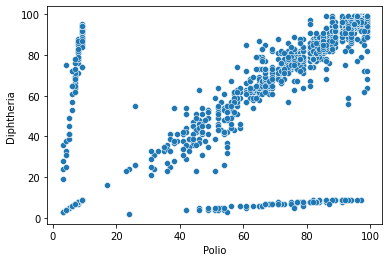

In [70]:
sns.scatterplot(x=dataframe['Polio'],y=dataframe['Diphtheria ']);

In [71]:
def impute_Diptheria(c):
    d=c[0]
    p=c[1]
    if pd.isnull(d):
        if p<=10:
            return train[train['Polio']<=10]['Diphtheria '].mean()
        elif 10<p<=40:
            return train[(10<train['Polio']) &(train['Polio'] <=40)]['Diphtheria '].mean()
        elif 40<p<=45:
            return train[(40<train['Polio']) &(train['Polio'] <=45)]['Diphtheria '].mean()
        elif 45<p<=50:
            return train[(45<train['Polio']) &(train['Polio'] <=50)]['Diphtheria '].mean()
        elif 50<p<=60:
            return train[(50<train['Polio']) &(train['Polio'] <=60)]['Diphtheria '].mean()
        elif 60<p<=80:
            return train[(60<train['Polio']) &(train['Polio'] <=80)]['Diphtheria '].mean()
        elif p>80:
            return train[train['Polio']>80]['Diphtheria '].mean()
    else:
        return d
train['Diphtheria ']=train[['Diphtheria ','Polio']].apply(impute_Diptheria,axis=1)


Similarly, we're gonna handle 'Hepatitis B' using 'Diptheria' feature.

<AxesSubplot:xlabel='Diphtheria ', ylabel='Hepatitis B'>

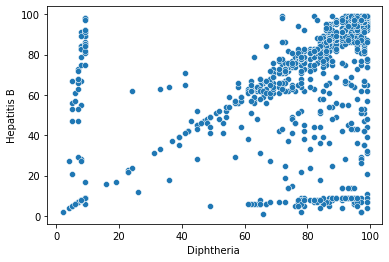

In [72]:
sns.scatterplot(x=dataframe['Diphtheria '],y=dataframe['Hepatitis B'])

In [73]:
def impute_HepatatisB(cols):
    hep=cols[0]
    dip=cols[1]
    if pd.isnull(hep):
        if dip<=15:
            return train[train['Diphtheria ']<=15]['Hepatitis B'].mean()
        elif 15<dip<=30:
            return train[(15<train['Diphtheria ']) &(train['Diphtheria '] <=30)]['Hepatitis B'].mean()
        elif 30<dip<=45:
            return train[(30<train['Diphtheria ']) &(train['Diphtheria '] <=45)]['Hepatitis B'].mean()
        elif 45<dip<=60:
            return train[(45<train['Diphtheria ']) &(train['Diphtheria '] <=60)]['Hepatitis B'].mean()
        elif 60<dip<=80:
            return train[(60<train['Diphtheria ']) &(train['Diphtheria '] <=80)]['Hepatitis B'].mean()
        elif dip>80:
            return train[train['Diphtheria ']>80]['Hepatitis B'].mean()
    else:
        return hep
    
train['Hepatitis B']=train[['Hepatitis B','Diphtheria ']].apply(impute_HepatatisB,axis=1)

Let's continue with the remaining feature which is not non-null

<AxesSubplot:xlabel='Life expectancy ', ylabel=' BMI '>

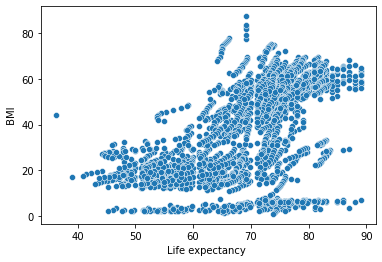

In [74]:
sns.scatterplot(x=dataframe['Life expectancy '],y=dataframe[' BMI '])

In [75]:
def impute_BMI(c):
    b=c[0]
    l=c[1]
    if pd.isnull(b):
        if l<=50:
            return train[train['Life expectancy ']<=50][' BMI '].mean()
        elif 50<l<=60:
            return train[(50<train['Life expectancy ']) &(train['Life expectancy '] <=60)][' BMI '].mean()
        elif 60<l<=70:
            return train[(60<train['Life expectancy ']) &(train['Life expectancy '] <=70)][' BMI '].mean()
        elif 70<l<=80:
            return train[(70<train['Life expectancy ']) &(train['Life expectancy '] <=80)][' BMI '].mean()
        elif 80<l<=100:
            return train[(80<train['Life expectancy ']) &(train['Life expectancy '] <=100)][' BMI '].mean()
    else:
        return b
    
train[' BMI ']=train[[' BMI ','Life expectancy ']].apply(impute_BMI,axis=1)

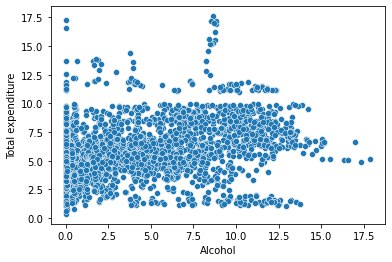

In [76]:
sns.scatterplot(y=dataframe['Total expenditure'],x=dataframe['Alcohol']);

In [77]:
def impute_Total_exp(c):
    t=c[0]
    a=c[1]
    if pd.isnull(t):
        if a<=2.5:
            return train[train['Alcohol']<=2.5]['Total expenditure'].mean()
        elif 2.5<a<=5.0:
            return train[(2.5<train['Alcohol']) &(train['Alcohol'] <=5.0)]['Total expenditure'].mean()
        elif 5.0<a<=10.0:
            return train[(5<train['Alcohol']) &(train['Alcohol'] <=10.0)]['Total expenditure'].mean()
        elif 10.0<a<=12.5:
            return train[(10<train['Alcohol']) &(train['Alcohol'] <=12.5)]['Total expenditure'].mean()
        elif a>12.5:
            return train[train['Alcohol']>12.5]['Total expenditure'].mean()
    else:
        return t
    
train['Total expenditure']=train[['Total expenditure','Alcohol']].apply(impute_Total_exp,axis=1)  

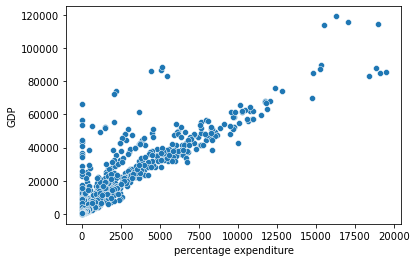

In [78]:
sns.scatterplot(x=dataframe['percentage expenditure'],y=dataframe['GDP']);

In [79]:
def impute_GDP(c):
    g=c[0]
    p=c[1]
    if pd.isnull(g):
        if p<=1250:
            return train[train['percentage expenditure']<=1250]['GDP'].mean()
        elif 1250<p<=2500:
            return train[(1250<train['percentage expenditure']) &(train['percentage expenditure'] <=2500)]['GDP'].mean()
        elif 2500<p<=3750:
            return train[(2500<train['percentage expenditure']) &(train['percentage expenditure'] <=3750)]['GDP'].mean()
        elif 3750<p<=7500:
            return train[(3750<train['percentage expenditure']) &(train['percentage expenditure'] <=7500)]['GDP'].mean()
        elif 7500<p<=8750:
            return train[(7500<train['percentage expenditure']) &(train['percentage expenditure'] <=8750)]['GDP'].mean()
        elif 8750<p<=10000:
            return train[(8750<train['percentage expenditure']) &(train['percentage expenditure'] <=10000)]['GDP'].mean()
        elif 10000<p<=11250:
            return train[(10000<train['percentage expenditure']) &(train['percentage expenditure'] <=11250)]['GDP'].mean()
        elif 11250<p<=12500:
            return train[(11250<train['percentage expenditure']) &(train['percentage expenditure'] <=12500)]['GDP'].mean()
        elif 12500<p<=15000:
            return train[(12500<train['percentage expenditure']) &(train['percentage expenditure'] <=15000)]['GDP'].mean()
        elif 15000<p<=17500:
            return train[(15000<train['percentage expenditure']) &(train['percentage expenditure'] <=17500)]['GDP'].mean()
        elif p>17500:
            return train[train['percentage expenditure']>17500]['GDP'].mean()
    else:
        return g
    
train['GDP']=train[['GDP','percentage expenditure']].apply(impute_GDP,axis=1)

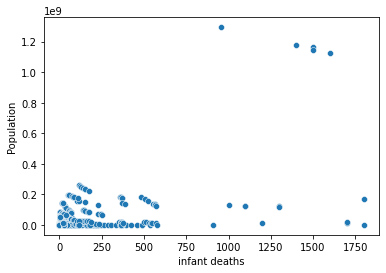

In [80]:
sns.scatterplot(x=dataframe['infant deaths'],y=dataframe['Population']);


In [81]:
def impute_population(c):
    p=c[0]
    i=c[1]
    if pd.isnull(p):
        if i<=100:
            return train[train['infant deaths']<=100]['Population'].mean()
        elif 100<i<=250:
            return train[(100<train['infant deaths']) &(train['infant deaths'] <=250)]['Population'].mean()
        elif 250<i<=350:
            return train[(250<train['infant deaths']) &(train['infant deaths'] <=350)]['Population'].mean()
        elif 350<i<=900:
            return train[(350<train['infant deaths']) &(train['infant deaths'] <=900)]['Population'].mean()
        elif 900<i<=1100:
            return train[(900<train['infant deaths']) &(train['infant deaths'] <=1100)]['Population'].mean()
        elif 1100<i<=1250:
            return train[(1100<train['infant deaths']) &(train['infant deaths'] <=1250)]['Population'].mean()
        elif 1250<i<=1500:
            return train[(1250<train['infant deaths']) &(train['infant deaths'] <=1500)]['Population'].mean()
        elif 1500<i<=1750:
            return train[(1500<train['infant deaths']) &(train['infant deaths'] <=1750)]['Population'].mean()
        elif i>1750:
            return train[train['infant deaths']>1750]['Population'].mean()
    else:
        return p
train['Population']=train[['Population','infant deaths']].apply(impute_population,axis=1)

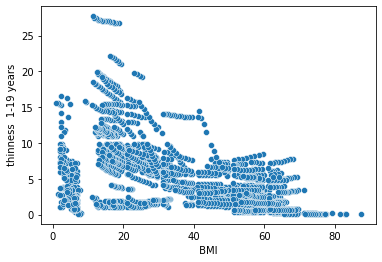

In [82]:
sns.scatterplot(x=dataframe[' BMI '],y=dataframe[' thinness  1-19 years']);

In [83]:
def impute_Thin_1(c):
    t=c[0]
    b=c[1]
    if pd.isnull(t):
        if b<=10:
            return train[train[' BMI ']<=10][' thinness  1-19 years'].mean()
        elif 10<b<=20:
            return train[(10<train[' BMI ']) &(train[' BMI '] <=20)][' thinness  1-19 years'].mean()
        elif 20<b<=30:
            return train[(20<train[' BMI ']) &(train[' BMI '] <=30)][' thinness  1-19 years'].mean()
        elif 30<b<=40:
            return train[(30<train[' BMI ']) &(train[' BMI '] <=40)][' thinness  1-19 years'].mean()
        elif 40<b<=50:
            return train[(40<train[' BMI ']) &(train[' BMI '] <=50)][' thinness  1-19 years'].mean()
        elif 50<b<=70:
            return train[(50<train[' BMI ']) &(train[' BMI '] <=60)][' thinness  1-19 years'].mean()
        elif b>70:
            return train[train[' BMI ']>70][' thinness  1-19 years'].mean()
    else:
        return t
    
train[' thinness  1-19 years']=train[[' thinness  1-19 years',' BMI ']].apply(impute_Thin_1,axis=1)

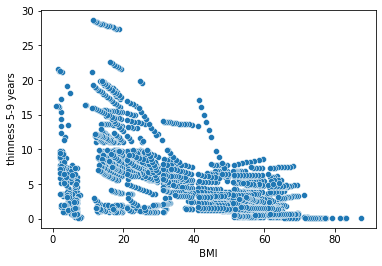

In [84]:
sns.scatterplot(x=dataframe[' BMI '],y=dataframe[' thinness 5-9 years']);

In [85]:
def impute_Thin_1(c):
    t=c[0]
    b=c[1]
    if pd.isnull(t):
        if b<=10:
            return train[train[' BMI ']<=10][' thinness 5-9 years'].mean()
        elif 10<b<=20:
            return train[(10<train[' BMI ']) &(train[' BMI '] <=20)][' thinness 5-9 years'].mean()
        elif 20<b<=30:
            return train[(20<train[' BMI ']) &(train[' BMI '] <=30)][' thinness 5-9 years'].mean()
        elif 30<b<=40:
            return train[(30<train[' BMI ']) &(train[' BMI '] <=40)][' thinness 5-9 years'].mean()
        elif 40<b<=50:
            return train[(40<train[' BMI ']) &(train[' BMI '] <=50)][' thinness 5-9 years'].mean()
        elif 50<b<=70:
            return train[(50<train[' BMI ']) &(train[' BMI '] <=70)][' thinness 5-9 years'].mean()
        elif b>70:
            return train[train[' BMI ']>70][' thinness 5-9 years'].mean()
    else:
        return t
    
train[' thinness 5-9 years']=train[[' thinness 5-9 years',' BMI ']].apply(impute_Thin_1,axis=1)

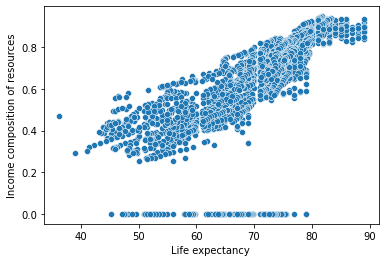

In [86]:
sns.scatterplot(x=dataframe['Life expectancy '],y=dataframe['Income composition of resources']);

In [87]:
def impute_Income(c):
    i=c[0]
    l=c[1]
    if pd.isnull(i):
        if l<=40:
            return train[train['Life expectancy '] <= 40]['Income composition of resources'].mean()
        elif 40<l<=50:
            return train[(40<train['Life expectancy ']) &(train['Life expectancy '] <=50)]['Income composition of resources'].mean()
        elif 50<l<=60:
            return train[(50<train['Life expectancy ']) &(train['Life expectancy '] <=60)]['Income composition of resources'].mean()
        elif 60<l<=70:
            return train[(60<train['Life expectancy ']) &(train['Life expectancy '] <=70)]['Income composition of resources'].mean()
        elif 70<l<=80:
            return train[(70<train['Life expectancy ']) &(train['Life expectancy '] <=80)]['Income composition of resources'].mean()
        elif l>80:
            return train[train['Life expectancy '] > 80]['Income composition of resources'].mean()
    else:
        return i
        
train['Income composition of resources']=train[['Income composition of resources','Life expectancy ']].apply(impute_Income,axis=1)  

<AxesSubplot:xlabel='Life expectancy ', ylabel='Schooling'>

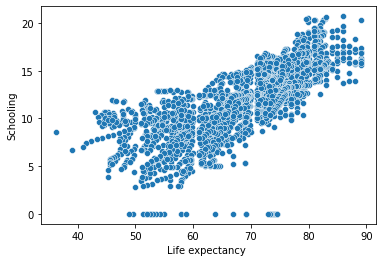

In [88]:
sns.scatterplot(x=dataframe['Life expectancy '],y=dataframe['Schooling'])

In [89]:
def impute_schooling(c):
    s=c[0]
    l=c[1]
    if pd.isnull(s):
        if l<= 40:
            return train[train['Life expectancy '] <= 40]['Schooling'].mean()
        elif 40<l<=44:
            return train[(40<train['Life expectancy ']) &(train['Life expectancy '] <=44)]['Schooling'].mean()
        elif 44<l<50:
            return train[(44<train['Life expectancy ']) &(train['Life expectancy '] <=50)]['Schooling'].mean()
        elif 50<l<=60:
            return train[(50<train['Life expectancy ']) &(train['Life expectancy '] <=60)]['Schooling'].mean()
        elif 60<l<=70:
            return train[(60<train['Life expectancy ']) &(train['Life expectancy '] <=70)]['Schooling'].mean()
        elif 70<l<=80:
            return train[(70<train['Life expectancy ']) &(train['Life expectancy '] <=80)]['Schooling'].mean()
        elif l>80:
            return train[train['Life expectancy '] > 80]['Schooling'].mean()
    else:
        return s
    
train['Schooling']=train[['Schooling','Life expectancy ']].apply(impute_schooling,axis=1)

Now. let's see if all the null values have been handle or not

In [90]:
columns = list(train.columns)
for i in columns:
    print(i, ": ", train[i].isnull().sum())

Year :  0
Life expectancy  :  0
Adult Mortality :  0
infant deaths :  0
Alcohol :  0
percentage expenditure :  0
Hepatitis B :  0
Measles  :  0
 BMI  :  0
under-five deaths  :  0
Polio :  0
Total expenditure :  0
Diphtheria  :  0
 HIV/AIDS :  0
GDP :  0
Population :  0
 thinness  1-19 years :  0
 thinness 5-9 years :  0
Income composition of resources :  0
Schooling :  0
Afghanistan :  0
Albania :  0
Algeria :  0
Angola :  0
Antigua and Barbuda :  0
Argentina :  0
Armenia :  0
Australia :  0
Austria :  0
Azerbaijan :  0
Bahamas :  0
Bahrain :  0
Bangladesh :  0
Barbados :  0
Belarus :  0
Belgium :  0
Belize :  0
Benin :  0
Bhutan :  0
Bolivia (Plurinational State of) :  0
Bosnia and Herzegovina :  0
Botswana :  0
Brazil :  0
Brunei Darussalam :  0
Bulgaria :  0
Burkina Faso :  0
Burundi :  0
Cabo Verde :  0
Cambodia :  0
Cameroon :  0
Canada :  0
Central African Republic :  0
Chad :  0
Chile :  0
China :  0
Colombia :  0
Comoros :  0
Congo :  0
Cook Islands :  0
Costa Rica :  0
Croatia

Now, let's discard any feature that has a great correlation with another feauture, we take 0.8 as a standard scale

In [91]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
droppable_features = list(correlation(dataframe, 0.8))
dataframe.drop(droppable_features, axis=1, inplace=True)

Now all null values have been filled. Let's turn all categorical features into numerical since our regressing tool can only handle numericals.

In [92]:
y_train=train['Life expectancy ']
X_train=train.drop('Life expectancy ',axis=1)
y_test=test['Life expectancy ']
X_test=test.drop('Life expectancy ',axis=1)



Outlier detection

In [93]:
df = pd.concat([y_train, y_test])
df.info()

<class 'pandas.core.series.Series'>
Int64Index: 2938 entries, 1641 to 1728
Series name: Life expectancy 
Non-Null Count  Dtype  
--------------  -----  
2938 non-null   float64
dtypes: float64(1)
memory usage: 45.9 KB


Now let's, do build our Ridge regression 

With Ridge Regress, there are 2 parameters that worth considering, they're 'tol' and 'alphal', let's consider with which value of each will maximize the score of our regression

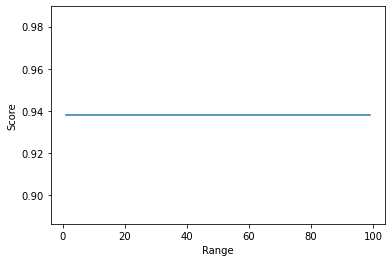

In [94]:
score_array = []
for each in range(1,100):
    ridge_reg = linear_model.Ridge(alpha=1, max_iter=100000, tol=each*0.01)
    ridge_reg.fit(X_train, y_train)
    score_array.append(ridge_reg.score(X_test,y_test))
    
plt.plot(range(1,100),score_array)
plt.xlabel("Range")
plt.ylabel("Score")
plt.show()

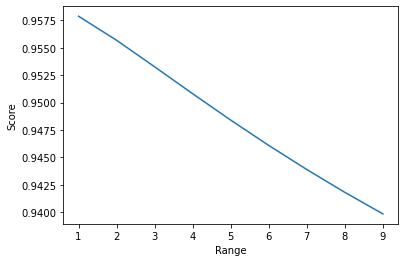

In [95]:
score_array = []
for each in range(1,10):
    ridge_reg = linear_model.Ridge(alpha=each*0.1, max_iter=100000, tol=0.01)
    ridge_reg.fit(X_train, y_train)
    score_array.append(ridge_reg.score(X_test,y_test))
    
plt.plot(range(1,10),score_array)
plt.xlabel("Range")
plt.ylabel("Score")
plt.show()

In [96]:
X_test

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe,Developed,Developing
2546,2006,123.0,8,0.97,122.652333,83.000000,517,48.5,10,83.0,...,0,0,0,0,0,0,0,0,0,1
650,2006,113.0,0,11.83,1555.651986,80.940461,1,58.1,0,96.0,...,0,0,0,0,0,0,0,0,1,0
1740,2007,125.0,0,4.98,678.518894,9.000000,0,57.2,0,92.0,...,0,0,0,0,0,0,0,0,0,1
177,2014,7.0,0,1.57,367.255674,98.000000,46,62.9,0,98.0,...,0,0,0,0,0,0,0,0,0,1
1377,2000,428.0,77,1.51,0.681686,80.940461,21002,14.4,121,8.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,2008,167.0,32,0.17,192.156300,66.000000,5494,54.5,38,71.0,...,0,0,0,0,0,0,0,0,0,1
1456,2001,228.0,0,6.68,332.275171,96.000000,1,55.7,0,97.0,...,0,0,0,0,0,0,0,0,1,0
123,2004,69.0,1,9.84,588.568371,95.000000,70,6.9,1,92.0,...,0,0,0,0,0,0,0,0,1,0
2509,2011,58.0,0,7.40,11477.667100,42.000000,26,57.7,0,98.0,...,0,0,0,0,0,0,0,0,1,0


From two plot above, we can see:
1, As the value of 'tol' changes, our score seems stable, so let's just take tol = 0.1 because it's common
2, As 'alpha' close to 0, our score increases, so let alpha be 0.01 to maximize our score

In [97]:
ridge_reg = linear_model.Ridge(alpha=0.01, max_iter=100000, tol=0.01)
ridge_reg.fit(X_train, y_train)
ridge_reg.score(X_test,y_test)


0.9593324393612652